# Base model development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [78]:
from model_class import CatBoostXT_BAG

## LOAD DATA

In [99]:
data_dir = r'E:\Project\Dissertation'

In [100]:
df = pd.read_parquet(rf'{data_dir}\data\processed\final_df.parquet').reset_index(drop=True)
df = df.replace({None: np.nan})

In [6]:
df.head()

,SK_ID_CURR,AGE_YEARS,EMPLOY_YEARS,REG_YEARS_AGO,ID_PUBLISH_YEARS_AGO,PHONE_CHANGE_YEARS_AGO,CREDIT_TO_INCOME,ANNUITY_TO_INCOME,ANNUITY_TO_CREDIT,GOODS_TO_CREDIT,...,bb_w24_status_3_share__mean,bb_w24_status_3_share__max,bb_w24_status_3_share__sum,bb_w24_status_4_share__mean,bb_w24_status_4_share__max,bb_w24_status_4_share__sum,bb_w24_status_5_share__mean,bb_w24_status_5_share__max,bb_w24_status_5_share__sum,TARGET
0,100002,25.920548,1.745205,9.994521,5.808219,3.106849,2.007889,0.121978,0.060749,0.863262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100003,45.931507,3.254795,3.249315,0.797260,2.268493,4.790750,0.132217,0.027598,0.873211,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0
2,100004,52.180822,0.616438,11.671233,6.934247,2.232877,2.000000,0.100000,0.050000,1.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0
3,100006,52.068493,8.326027,26.939726,6.676712,1.690411,2.316167,0.219900,0.094941,0.949845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,54.608219,8.323288,11.810959,9.473973,3.030137,4.222222,0.179963,0.042623,1.000000,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0


In [118]:
# separate features, target
list_features = [col for col in df.columns if col not in ['TARGET','SK_ID_CURR']]
# features that starts with EXT_
list_ext_features = [col for col in df.columns if col.startswith('EXT_')]
list_key = ['SK_ID_CURR']
label_col = 'TARGET'

In [119]:
list_ext_features

['EXT_MIN', 'EXT_MAX', 'EXT_MEAN', 'EXT_STD', 'EXT_VAR', 'EXT_SPAN']

In [102]:
list_cat_features = df.select_dtypes(include=['object','category']).columns.tolist()
list_cat_features

['w30_last_loan_type',
 'w90_last_loan_type',
 'w180_last_loan_type',
 'w360_last_loan_type',
 'w720_last_loan_type']

In [103]:
df[list_cat_features] = df[list_cat_features].fillna('Missing')

In [120]:
len(list(set(list_features)-set(list_ext_features)))

470

In [121]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(df[list(set(list_features)-set(list_ext_features))], df[label_col], test_size=0.25, random_state=1, stratify=df[label_col])

In [122]:
y_train

226530    0
130214    0
91848     0
249063    0
20697     0
         ..
276129    1
252261    0
215416    0
88067     0
232520    1
Name: TARGET, Length: 230633, dtype: int64

In [123]:
# summary of train test split data, count of target variable
print('Train set shape:', X_train.shape, y_train.shape)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print('Test set shape:', X_test.shape, y_test.shape)
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Train set shape: (230633, 470) (230633,)
TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64
TARGET
0    212014
1     18619
Name: count, dtype: int64
Test set shape: (76878, 470) (76878,)
TARGET
0    0.919275
1    0.080725
Name: proportion, dtype: float64
TARGET
0    70672
1     6206
Name: count, dtype: int64


In [124]:
base_model = CatBoostXT_BAG(
    num_bag_folds=5,
    num_bag_repeats=2,
    random_state=1,
    cat_features=list_cat_features
)

In [126]:
base_model.params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 5,
    'l2_leaf_reg': 25,
    'border_count': 128,
    'auto_class_weights': 'SqrtBalanced',
    'early_stopping_rounds': None,
    'od_type': 'IncToDec',
    'od_wait': 100,
    'od_pval': 0.005,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'loss_function': 'Logloss', 
    'eval_metric': 'Logloss',
    'task_type':'GPU',
    'devices':'0',
}

In [127]:
base_model.fit(X_train, y_train)

In [64]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

In [130]:
base_model.evaluate(X_train,y_train)

{'ROC_AUC': 0.7529699554557252, 'PR_AUC': 0.25486544389401133}

In [131]:
base_model.evaluate(X_test,y_test)

{'ROC_AUC': 0.734609133014557, 'PR_AUC': 0.2151324348023676}

In [132]:
2*roc_auc_score(y_train,base_model.predict_proba(X_train)[:, 1]) - 1

0.5059399109114504

In [133]:
2*roc_auc_score(y_test,base_model.predict_proba(X_test)[:, 1]) - 1

0.469218266029114

In [135]:
# dump base_model to pickle
import pickle
with open(rf'{data_dir}\models\catboostxt_bag_base_model.pkl', 'wb') as f:
    pickle.dump(base_model, f)

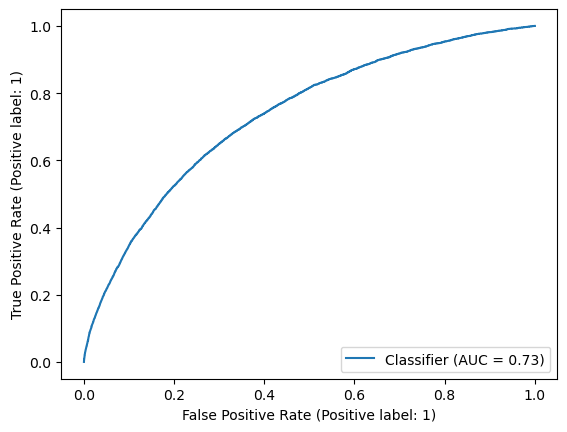

In [134]:
# Draw ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, base_model.predict_proba(X_test)[:, 1])

In [136]:
# Draw shap summary plot from the base_model get_average_shap_values
base_model.get_average_shap_feature_importance(X_train)


{'ANNUITY_TO_CREDIT': 0.18846456867980985,
 'CODE_GENDER_FREQ': 0.13928595497313462,
 'GOODS_TO_CREDIT': 0.13696984820131697,
 'NAME_EDUCATION_TYPE_FREQ': 0.1308875858474448,
 'PHONE_CHANGE_YEARS_AGO': 0.1258525020885259,
 'AGE_YEARS': 0.11667130116431484,
 'EMPLOY_YEARS': 0.0952197749779939,
 'NAME_INCOME_TYPE_FREQ': 0.0856518929857001,
 'w720_utilization_portfolio': 0.08085482006057576,
 'ANNUITY_TO_INCOME': 0.07306510602001914,
 'NAME_FAMILY_STATUS_FREQ': 0.0725535688943371,
 'ID_PUBLISH_YEARS_AGO': 0.07127913667768307,
 'w720_vintage_fraction': 0.060370618849643086,
 'ENV_COVERAGE': 0.057134137323146254,
 'w360_avg_days_remaining': 0.05334353062781891,
 'w720_n_active_loans': 0.05324156982883567,
 'w720_max_overdue_amt': 0.04948159148645301,
 'w360_utilization_portfolio': 0.04650079174066489,
 'ASSET_FLAGS_SUM': 0.04392904182027626,
 'REQ_RECENT_RATIO': 0.039637415149622296,
 'HOUR_SIN': 0.03956067293016823,
 'TENURE_OVER_AGE': 0.03911675089987097,
 'DOCS_MISSING_RATIO': 0.03654328

In [140]:
# for model in base_model.models plot the shap summary plot using the average shap values
for i, model in enumerate(base_model.models):
    print(f'Model {i+1}')
    shap_values = model.get_feature_importance(type='ShapValues', data=base_model.prepare_data(X_test))
    # The last column is the expected value, so we need to exclude it
    shap_values_only += shap_values[:, :-1]

shap_values_only = shap_values_only / len(base_model.models)

# Plot summary plot
import shap
shap.summary_plot(shap_values_only, X_test, show=False)
plt.title(f'Shap Summary Plot for Model {i+1}')
plt.show()

Model 1


ValueError: operands could not be broadcast together with shapes (230633,470) (76878,470) (230633,470) 